# Wstęp do uczenia maszynowego - praca domowa nr 3

#### Budowniczy: Jędrzej Sokołowski, Filip Szympliński
#### Walidatorzy: Malwina Wojewoda i Jakub Piwko

### Wczytanie pakietów oraz danych

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
import copy
warnings.filterwarnings('ignore')

# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (10,5)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16
# ustawia wielkość tekstów dla wykresów seaborn zależną od wielkości wykresu
sns.set_context('paper', font_scale=1.4)

In [2]:
data = pd.read_csv("data.csv", sep=",")

In [3]:
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [4]:
# w pliku budowniczych odwrotna konwencja nazywania zbioru testowego i walidacyjnego
from sklearn.model_selection import train_test_split

X = data.drop("Bankrupt?", axis=1)
y = data["Bankrupt?"]
y = y.astype('int')

X_train_test, X_val, y_train_test, y_val = train_test_split(X, y, random_state=420, test_size=0.2)

In [5]:
data_train_test = pd.concat([X_train_test, y_train_test], axis = 1)
data_val = pd.concat([X_val, y_val], axis=1)

Wydaje nam się, że podział danych na:
* 0.7*0.7 -> zbiór treningowy
* 0.7*0.3 -> zbiór testowy
* 0.3 -> zbiór walidacyjny

mógłby być trochę lepszy, jednak zostajemy przy takim, w jaki podzielił ten zbiór zespół budujący. 

### Analiza braków danych

In [6]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1364 entries, 4764 to 2487
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0    ROA(C) before interest and depreciation before interest  1364 non-null   float64
 1    ROA(A) before interest and % after tax                   1364 non-null   float64
 2    ROA(B) before interest and depreciation after tax        1364 non-null   float64
 3    Operating Gross Margin                                   1364 non-null   float64
 4    Realized Sales Gross Margin                              1364 non-null   float64
 5    Operating Profit Rate                                    1364 non-null   float64
 6    Pre-tax net Interest Rate                                1364 non-null   float64
 7    After-tax net Interest Rate                              1364 non-null   float64
 8    Non-industry i

Wszystkie dane są liczbami

In [7]:
sum(list(data_val.isna().sum()))

0

In [8]:
sum(data_val[data_val == -1].count())

0

W zbiorze walidacyjnym nie ma braków danych, tak samo jak było w zbiorze treningowym.

<AxesSubplot:xlabel='Bankrupt?', ylabel='count'>

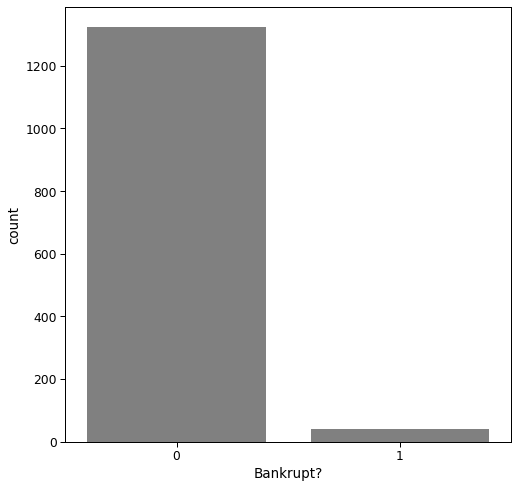

In [9]:
sns.countplot(x="Bankrupt?", data=data_val, color='gray')

Proporcje klas mają identyczne proporcje w zbiorze walidacyjnym. 

---

## Preprocessing

### Outliery

Outliery zastępimy wartościami granicznymi, policzonymi dla zbioru treningowego, dla którego przedział outlierów jest przy 2,5% końców przedziałów. 

In [10]:
#przed
data_val.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
count,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,...,1.364000e+03,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.0,1364.000000,1364.000000
mean,0.505489,0.558745,0.553521,0.607703,0.607706,0.998930,0.797268,0.809180,0.303394,0.781522,...,2.281085e+07,0.624352,0.607701,0.840348,0.280420,0.027350,0.565732,1.0,0.049202,0.030059
std,0.061609,0.067980,0.062403,0.024151,0.024163,0.001192,0.005019,0.004808,0.006636,0.002140,...,4.379566e+08,0.016039,0.024151,0.012856,0.020809,0.009770,0.007767,0.0,0.050826,0.170811
min,0.216984,0.090711,0.171637,0.000000,0.000000,0.962961,0.616328,0.636191,0.062507,0.712333,...,1.085313e-04,0.408682,0.000000,0.442176,0.199162,0.020760,0.500799,1.0,0.008950,0.000000
25%,0.477502,0.535775,0.528187,0.600906,0.600881,0.998971,0.797389,0.809314,0.303468,0.781569,...,9.064894e-04,0.623644,0.600904,0.840140,0.276820,0.026791,0.565158,1.0,0.025311,0.000000
50%,0.501828,0.558929,0.551314,0.606606,0.606621,0.999020,0.797467,0.809377,0.303528,0.781636,...,2.000487e-03,0.623879,0.606606,0.841103,0.278586,0.026807,0.565241,1.0,0.034999,0.000000
75%,0.535941,0.588244,0.583971,0.614260,0.614233,0.999099,0.797577,0.809468,0.303588,0.781734,...,4.912516e-03,0.624149,0.614258,0.842337,0.281100,0.026913,0.565723,1.0,0.055371,0.000000
max,1.000000,0.954536,0.957760,0.665151,0.665151,0.999644,0.809513,0.821053,0.329207,0.795631,...,9.390000e+09,1.000000,0.665149,0.902744,1.000000,0.367190,0.735958,1.0,0.881018,1.000000


In [11]:
col_names = data_val.columns
for col in col_names:
    tmp_data1 = data_train_test[col]
    upper_lim1 = tmp_data1.quantile(.975)
    lower_lim1 = tmp_data1.quantile(.025)
    data_val[col] = np.where(data_val[col] < upper_lim1, data_val[col], upper_lim1)
    data_val[col] = np.where(data_val[col] > lower_lim1, data_val[col], lower_lim1)

Naszym zdaniem podział na zbiór treninowy i testowy powinien nastąpić wcześniej i w tym przypadku sprawdzać te 2,5% outlierów wyłącznie na danych treningowych, ponieważ dla danych testowych dane graniczne powinny być takie same jak w zbiorze treninowym, a nie odpowaiadające takiemu samemu stosunkowi. Skoro jednak grupa budowniczych tak zrobiła to zrobimy tak samo, aby porówananie było miarodajne.

In [12]:
#po
data_val.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
count,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,...,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.000000,1364.0,1364.000000,1364.000000
mean,0.505404,0.559104,0.553957,0.608550,0.608546,0.999017,0.797442,0.809352,0.303524,0.781611,...,0.006049,0.623837,0.608548,0.840863,0.279591,0.026952,0.565499,1.0,0.046547,0.030059
std,0.052584,0.054480,0.052219,0.010922,0.010932,0.000154,0.000262,0.000236,0.000209,0.000244,...,0.012852,0.001068,0.010923,0.002501,0.003843,0.000566,0.001308,0.0,0.032206,0.170811
min,0.384173,0.418096,0.427654,0.589694,0.589667,0.998492,0.796485,0.808469,0.302887,0.780734,...,0.000252,0.619922,0.589691,0.832546,0.275320,0.026090,0.561494,1.0,0.015390,0.000000
25%,0.477502,0.535775,0.528187,0.600906,0.600881,0.998971,0.797389,0.809314,0.303468,0.781569,...,0.000906,0.623644,0.600904,0.840140,0.276820,0.026791,0.565158,1.0,0.025311,0.000000
50%,0.501828,0.558929,0.551314,0.606606,0.606621,0.999020,0.797467,0.809377,0.303528,0.781636,...,0.002000,0.623879,0.606606,0.841103,0.278586,0.026807,0.565241,1.0,0.034999,0.000000
75%,0.535941,0.588244,0.583971,0.614260,0.614233,0.999099,0.797577,0.809468,0.303588,0.781734,...,0.004913,0.624149,0.614258,0.842337,0.281100,0.026913,0.565723,1.0,0.055371,0.000000
max,0.627078,0.675313,0.670408,0.640523,0.640311,0.999326,0.797918,0.809763,0.304101,0.782045,...,0.074388,0.626991,0.640524,0.845016,0.292928,0.029803,0.569747,1.0,0.158080,1.000000


Zastąpienie outlierów wartościami granicznymi jest jak najbardziej w porządku. Jak widać w sumarycznych statystykach dla danych przed i po, niektóre zmienne miały wyraźnie odstające wartości. Udało nam się zmniejszyc ochylenie standardowe, a średnia arytmetyczna w kolumnach pozostała bardzo zbliżona do tej sprzed zamianą outlierów.

### Skalowanie

Podobnie jak dla zbiory treningowego, wszystkie kolumny, których wartości nie zawierają się w przedziale [0, 1] zostaną przeskalowane.

In [13]:
cols_to_scale = []
for col in data_val.columns:
    if data[col].max() > 1:
        cols_to_scale.append(col)
print(cols_to_scale)
len(cols_to_scale)

[' Operating Expense Rate', ' Research and development expense rate', ' Interest-bearing debt interest rate', ' Revenue Per Share (Yuan ¥)', ' Total Asset Growth Rate', ' Net Value Growth Rate', ' Current Ratio', ' Quick Ratio', ' Total debt/Total net worth', ' Accounts Receivable Turnover', ' Average Collection Days', ' Inventory Turnover Rate (times)', ' Fixed Assets Turnover Frequency', ' Revenue per person', ' Allocation rate per person', ' Quick Assets/Current Liability', ' Cash/Current Liability', ' Inventory/Current Liability', ' Long-term Liability to Current Assets', ' Current Asset Turnover Rate', ' Quick Asset Turnover Rate', ' Cash Turnover Rate', ' Fixed Assets to Assets', ' Total assets to GNP price']


24

Kolumny, które wymagają przeskalowania są dokładnie takie same jak te, które wymagały go w zbiorze testowym.

In [14]:
for col in cols_to_scale:
    min_max_scaler1 = MinMaxScaler()
    scaled_col1 = min_max_scaler1.fit_transform(data_val[col].values.reshape(-1, 1))
    data_val[col] = scaled_col1

### Redukcja zmiennych silnie skorelowanych

In [15]:
#kopia danych żeby zrobić na nich inny rodzaj redukcji niż został zrobiony dla zbioru testowego
import copy 
data_copy = copy.deepcopy(data_val)

In [16]:
correlated_features = set()
corr = data_val.corr(method = 'spearman')
for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= 0.95:
            colname = corr.columns[i]
            correlated_features.add(colname)

In [17]:
print(correlated_features)
print(len(correlated_features))
len(correlated_features)/data_val.shape[1]

{' Realized Sales Gross Margin', ' Equity to Liability', ' Liability to Equity', ' Operating Funds to Liability', ' Current Liability to Liability', ' Cash Flow to Equity', ' Persistent EPS in the Last Four Seasons', ' Net Income to Total Assets', ' CFO to Assets', ' Gross Profit to Sales', ' Current Liabilities/Equity', ' Per Share Net profit before tax (Yuan ¥)', ' Cash Flow to Liability', ' After-tax net Interest Rate', ' Net Value Per Share (C)', ' Net worth/Assets', " Net Income to Stockholder's Equity", ' Net profit before tax/Paid-in capital', ' Quick Assets/Current Liability', ' Continuous interest rate (after tax)', ' ROA(B) before interest and depreciation after tax', ' Fixed Assets to Assets', ' Operating profit/Paid-in capital', ' Current Liability to Equity', ' Cash Flow to Total Assets', ' Regular Net Profit Growth Rate', ' Current Liability to Current Assets', ' Debt ratio %', ' Net Value Per Share (A)'}
29


0.3020833333333333

In [18]:
data_val.drop(labels=correlated_features, axis=1, inplace=True)

Na zbiorze walidacyjnym również 29 kolumn spełniło warunek wysokiej korelacji i tak samo je usunęliśmy. 

W zbiorze testowym były one usuwane losowo (więc tak samo zrobiliśmy dla walidayjnego), jednak lepszym rozwiązaniem wydaje się nam usuwanie tych kolumn, które mają gorszą predykcyjność. W przykładzie poniżej wykorzystaliśmy Feature Importance dla modelu Random Forest.

In [19]:
from sklearn.ensemble import RandomForestClassifier

corr = data_copy.corr(method = 'spearman')
y = data_copy['Bankrupt?']
X = data_copy.drop('Bankrupt?', axis = 1)

Forest = RandomForestClassifier()
Forest.fit(X, y)
fi = Forest.feature_importances_
correlated_features = set()


for i in range(len(corr .columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) >= 0.95:
            if fi[i] >= fi[j]:
                correlated_features.add(corr.columns[i])
            else:
                correlated_features.add(corr.columns[j])

In [20]:
print(correlated_features)
print(len(correlated_features))
len(correlated_features)/X.shape[1]

{' Operating Profit Per Share (Yuan ¥)', ' Total debt/Total net worth', ' Net Value Per Share (B)', ' Liability to Equity', ' Operating Gross Margin', ' Current Liability to Liability', ' Cash Flow to Equity', ' Persistent EPS in the Last Four Seasons', ' Net Income to Total Assets', ' Current Ratio', ' Cash Flow to Sales', ' Gross Profit to Sales', ' Current Liabilities/Equity', ' After-tax net Interest Rate', ' Net worth/Assets', " Net Income to Stockholder's Equity", ' Net profit before tax/Paid-in capital', ' After-tax Net Profit Growth Rate', ' Long-term fund suitability ratio (A)', ' Quick Ratio', ' Cash Flow Per Share', ' Continuous interest rate (after tax)', ' Cash flow rate', ' ROA(B) before interest and depreciation after tax', ' Current Liability to Equity', ' Cash Flow to Total Assets', ' Debt ratio %', ' Net Value Per Share (A)', ' ROA(A) before interest and % after tax'}
29


0.30526315789473685

Korzystając z tego sposobu dostaliśmy w wyniku nieco inne kolumny do usunięcia. Można się też zastanowić nad wyborem mniejszego progu korelacji, choć delikatne zmniejszenie progu dla tego zbioru szybko zwiększa liczbę kolumn do usunięcia, więc wydaje się, że korelacja na poziomie 0.95 i 29 zmiennych to optymalne wartości, aby nie pozbyć się za dużo informacji.

### Zmiana kierunku zmiennych

In [21]:
corr = data_val.corr(method = 'spearman')
(corr["Bankrupt?"] < 0).sum()

44

In [22]:
columns = data_val.drop("Bankrupt?", axis=1).columns
for col in columns:
    if corr["Bankrupt?"][col] < 0:
      data_val[col] *= -1

In [23]:
corr = data_val.corr(method = 'spearman')
(corr["Bankrupt?"] < 0).sum()

0

W zbiorze walidacyjnym jedna zmienna mniej miała ujemną korelacją Spearmana niż jak było to w przypadku zbioru testowego. Zapewne była to zmienna, której moduł korelacji jest bardzo mały.  

### Przygotowanie danych do budowania modeli

In [24]:
def preprocessing(df):
    col_names = df.columns
    indexes_set = set()
    num_of_outliers = []

    for col in col_names:
        tmp_data1 = df[col]
        upper_lim1 = tmp_data1.quantile(.975)
        lower_lim1 = tmp_data1.quantile(.025)
        df[col] = np.where(data_train_test[col] < upper_lim1, data_train_test[col], upper_lim1)
        df[col] = np.where(data_train_test[col] > lower_lim1, data_train_test[col], lower_lim1)

    cols_to_scale = []
    for col in df.columns:
        if df[col].max() > 1:
            cols_to_scale.append(col)

    for col in cols_to_scale:
        min_max_scaler1 = MinMaxScaler()
        scaled_col1 = min_max_scaler1.fit_transform(df[col].values.reshape(-1, 1))
        df[col] = scaled_col1

    corr = df.corr(method = 'spearman')
    correlated_features = set()

    for i in range(len(corr .columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) >= 0.95:
                colname = corr.columns[i]
                correlated_features.add(colname)

    df.drop(labels=correlated_features, axis=1, inplace=True)

    columns = df.drop("Bankrupt?", axis=1).columns

    for col in columns:
        if corr["Bankrupt?"][col] < 0:
          df[col] *= -1
        
    return df

In [25]:
data_train_test = preprocessing(data_train_test)

In [26]:
#Podział na treningowy i testowy
from sklearn.model_selection import train_test_split

X = data_train_test.drop("Bankrupt?", axis=1)
y = data_train_test["Bankrupt?"]
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420, test_size=0.125)

In [27]:
X_val = data_val.drop("Bankrupt?", axis=1)
y_val = data_val["Bankrupt?"]
y_val = y_val.astype('int')

## Modelowanie

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_predict
from tqdm.notebook import tqdm

In [40]:
def show_model_metrics(model, X, y):
    y_pred = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, y_pred)}")
    print(f"F1 score: {f1_score(y, y_pred, average=None)}")
    print(f"F1 score micro: {f1_score(y, y_pred, average='micro')}")
    print(f"F1 score weighted: {f1_score(y, y_pred, average='weighted')}")
    print(f"Precision score: {precision_score(y, y_pred, average=None)}")
    print(f"Recall score: {recall_score(y, y_pred, average=None)}")

## Klasyfikator `XGBClassifier`

In [41]:
xgb_clf = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(xgb_clf, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(xgb_clf, X_val, y_val)

[15:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--------------------------------------------------
Train set scores
Accuracy: 1.0
F1 score: [1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1.]
Recall score: [1. 1.]
--------------------------------------------------
Validation set scores
Accuracy: 0.9699413489736071
F1 score: [0.98474135 0.        ]
F1 score micro: 0.9699413489736071
F1 score weighted: 0.955141350719823
Precision score: [0.96994135 0.        ]
Recall score: [1. 0.]


In [42]:
#dodane parametry: max_depth=2, learning_rate=0.3 
xgb_clf = xgb.XGBClassifier(random_state=1,
                    booster='gbtree', 
                    use_label_encoder=False,
                    max_depth=2,
                    learning_rate=0.3
                    )
xgb_clf.fit(X_train, y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(xgb_clf, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(xgb_clf, X_val, y_val)

[15:29:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
--------------------------------------------------
Train set scores
Accuracy: 0.9935051330400168
F1 score: [0.99665335 0.89045936]
F1 score micro: 0.9935051330400168
F1 score weighted: 0.9931825240252925
Precision score: [0.99354283 0.99212598]
Recall score: [0.99978341 0.80769231]
--------------------------------------------------
Validation set scores
Accuracy: 0.9699413489736071
F1 score: [0.98474135 0.        ]
F1 score micro: 0.9699413489736071
F1 score weighted: 0.955141350719823
Precision score: [0.96994135 0.        ]
Recall score: [1. 0.]


Sprawdzimy też jak wybór poszczególnych parametrów wpływa na model.

***n_estimators***

  0%|          | 0/25 [00:00<?, ?it/s]

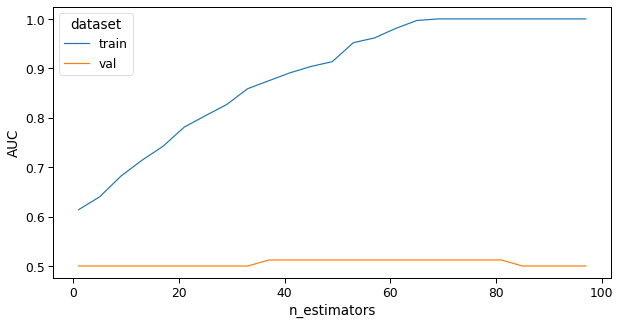

In [63]:
cols = ["n_estimators","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

estimators = np.arange(1,100,4)
for trees_nr in tqdm(estimators):
    xgb_clf = xgb.XGBClassifier(n_estimators=trees_nr, max_depth=3, eval_metric='logloss').fit(X_train, y_train)
    train_score = roc_auc_score(y_train, xgb_clf.predict(X_train))
    val_score = roc_auc_score(y_val, xgb_clf.predict(X_val))
    history = history.append(dict(zip(cols, [trees_nr, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [trees_nr, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_estimators", y = "AUC", hue = "dataset")
plt.show()

***n_depth***

  0%|          | 0/19 [00:00<?, ?it/s]

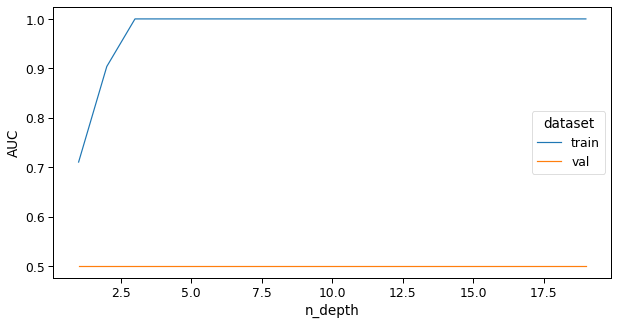

In [61]:
cols = ["n_depth","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

n_depth = np.arange(1,20,1)
for depth in tqdm(n_depth):
    xgb_clf = xgb.XGBClassifier(max_depth=depth, eval_metric='logloss').fit(X_train, y_train)
    train_score = roc_auc_score(y_train,xgb_clf.predict(X_train))
    val_score = roc_auc_score(y_val,xgb_clf.predict(X_val))
    history = history.append(dict(zip(cols, [depth, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [depth, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_depth", y = "AUC", hue = "dataset")
plt.show()

***n_learning_rate***

  0%|          | 0/10 [00:00<?, ?it/s]

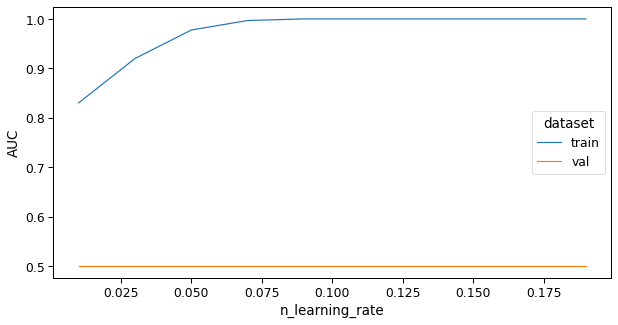

In [62]:
cols = ["n_learning_rate","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

n_rate = np.arange(0.01,0.2,0.02)
for rate in tqdm(n_rate):
    xgb_clf = xgb.XGBClassifier(learning_rate=rate, eval_metric='logloss').fit(X_train, y_train)
    train_score = roc_auc_score(y_train,xgb_clf.predict(X_train))
    val_score = roc_auc_score(y_val,xgb_clf.predict(X_val))
    history = history.append(dict(zip(cols, [rate, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [rate, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_learning_rate", y = "AUC", hue = "dataset")
plt.show()

# nie wiem w ogole co to jakie z tego wnioski i w ogole czy to jest dobrze w tych recall score też nie wiem czym jest ten drugi parmetr, jakaś masakra


***
***

## Klasyfikator `RandomForestClassifier`

In [45]:
rndForest = RandomForestClassifier()
rndForest.fit(X_train, y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(rndForest, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(rndForest, X_val, y_val)

--------------------------------------------------
Train set scores
Accuracy: 1.0
F1 score: [1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1.]
Recall score: [1. 1.]
--------------------------------------------------
Validation set scores
Accuracy: 0.9699413489736071
F1 score: [0.98474135 0.        ]
F1 score micro: 0.9699413489736071
F1 score weighted: 0.955141350719823
Precision score: [0.96994135 0.        ]
Recall score: [1. 0.]


***n_estiamtors***

  0%|          | 0/20 [00:00<?, ?it/s]

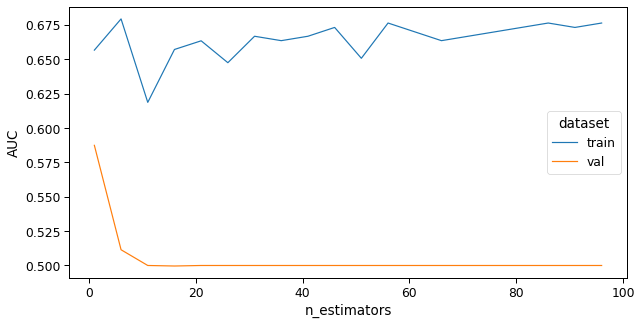

In [67]:
cols = ["n_estimators","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

estimators = np.arange(1,100,5)
for trees_nr in tqdm(estimators):
    rf = RandomForestClassifier(n_estimators=trees_nr, max_depth=5, n_jobs=-1).fit(X_train, y_train)
    train_score = roc_auc_score(y_train, rf.predict(X_train))
    val_score = roc_auc_score(y_val, rf.predict(X_val))
    history = history.append(dict(zip(cols, [trees_nr, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [trees_nr, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_estimators", y = "AUC", hue = "dataset")
plt.show()

***n_depth***

  0%|          | 0/19 [00:00<?, ?it/s]

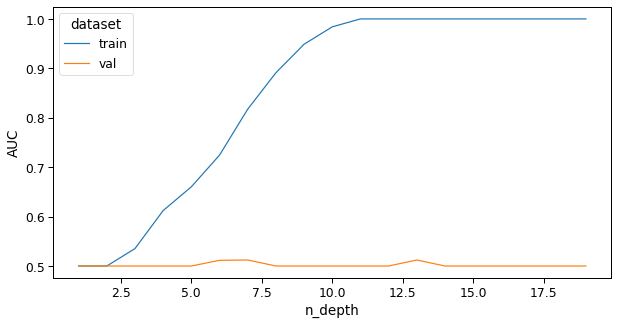

In [70]:
cols = ["n_depth","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

n_depth = np.arange(1,20,1)
for depth in tqdm(n_depth):
    rf = RandomForestClassifier(max_depth=depth, n_jobs=-1, n_estimators=100).fit(X_train, y_train)
    train_score = roc_auc_score(y_train,rf.predict(X_train))
    val_score = roc_auc_score(y_val,rf.predict(X_val))
    history = history.append(dict(zip(cols, [depth, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [depth, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_depth", y = "AUC", hue = "dataset")
plt.show()

---

RandomForestClassifier z hiperparametrami: max_depth = 6, n_estimators=100

In [71]:
rndForest = RandomForestClassifier(max_depth = 6, n_estimators=100)
rndForest.fit(X_train, y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(rndForest, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(rndForest, X_val, y_val)

--------------------------------------------------
Train set scores
Accuracy: 0.9832390530064948
F1 score: [0.99141078 0.65517241]
F1 score micro: 0.9832390530064948
F1 score weighted: 0.9804212162943333
Precision score: [0.98296785 1.        ]
Recall score: [1.         0.48717949]
--------------------------------------------------
Validation set scores
Accuracy: 0.9699413489736071
F1 score: [0.98474135 0.        ]
F1 score micro: 0.9699413489736071
F1 score weighted: 0.955141350719823
Precision score: [0.96994135 0.        ]
Recall score: [1. 0.]


## Klasyfikator `DecisionTreeClassifier`

In [72]:
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(d_tree, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(d_tree, X_val, y_val)

--------------------------------------------------
Train set scores
Accuracy: 1.0
F1 score: [1. 1.]
F1 score micro: 1.0
F1 score weighted: 1.0
Precision score: [1. 1.]
Recall score: [1. 1.]
--------------------------------------------------
Validation set scores
Accuracy: 0.9435483870967742
F1 score: [0.97050938 0.34188034]
F1 score micro: 0.9435483870967742
F1 score weighted: 0.9516136423945817
Precision score: [0.98369565 0.26315789]
Recall score: [0.95767196 0.48780488]


***n_features***

  0%|          | 0/29 [00:00<?, ?it/s]

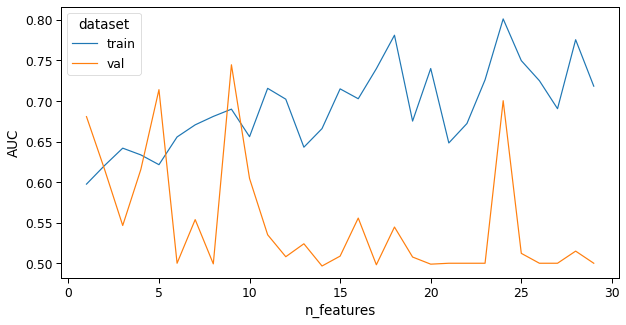

In [76]:
cols = ["n_features","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

estimators = np.arange(1,30,1)
for trees_nr in tqdm(estimators):
    rf = DecisionTreeClassifier(max_features=trees_nr, max_depth=5, random_state=1).fit(X_train, y_train)
    train_score = roc_auc_score(y_train, rf.predict(X_train))
    val_score = roc_auc_score(y_val, rf.predict(X_val))
    history = history.append(dict(zip(cols, [trees_nr, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [trees_nr, val_score, "val"])), ignore_index=True)

sns.lineplot(data=history, x = "n_features", y = "AUC", hue = "dataset")
plt.show()

***n_depth***

  0%|          | 0/9 [00:00<?, ?it/s]

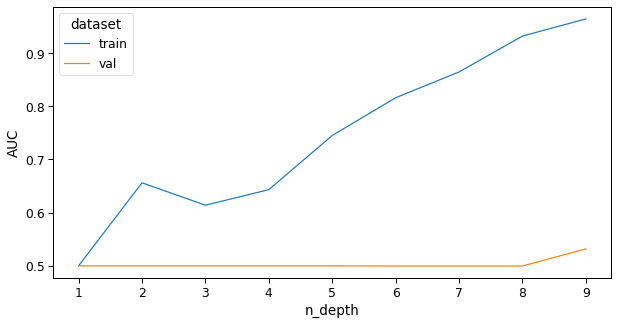

In [77]:
cols = ["n_depth","AUC", "dataset"]
history = pd.DataFrame(columns=cols)

n_depth = np.arange(1,10,1)
for depth in tqdm(n_depth):
    rf = DecisionTreeClassifier(max_depth=depth, random_state=1).fit(X_train, y_train)
    train_score = roc_auc_score(y_train,rf.predict(X_train))
    val_score = roc_auc_score(y_val,rf.predict(X_val))
    history = history.append(dict(zip(cols, [depth, train_score, "train"])), ignore_index=True)
    history = history.append(dict(zip(cols, [depth, val_score, "val"])), ignore_index=True)
    
sns.lineplot(data=history, x = "n_depth", y = "AUC", hue = "dataset")
plt.show()

RandomForestClassifier z hiperparametrami: max_depth = 6, n_estimators=30

In [78]:
d_tree = DecisionTreeClassifier(max_depth=6, max_features=30, random_state=1)
d_tree.fit(X_train,y_train)

print("--------------------------------------------------")
print("Train set scores")
show_model_metrics(d_tree, X_train, y_train)

print("--------------------------------------------------")
print("Validation set scores")
show_model_metrics(d_tree, X_val, y_val)

--------------------------------------------------
Train set scores
Accuracy: 0.9819819819819819
F1 score: [0.99073076 0.67910448]
F1 score micro: 0.9819819819819819
F1 score weighted: 0.9805456152874055
Precision score: [0.98605449 0.8125    ]
Recall score: [0.99545159 0.58333333]
--------------------------------------------------
Validation set scores
Accuracy: 0.9149560117302052
F1 score: [0.95524691 0.14705882]
F1 score micro: 0.9149560117302052
F1 score weighted: 0.9309538698177219
Precision score: [0.97557132 0.10526316]
Recall score: [0.93575208 0.24390244]


## Podsumowanie